# Проект: Сеть фитнес-центров «Культурист-датасаентист». План действий по удержанию клиентов.

<a id="num1"></a>
## Цели

- Научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента.
- Сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства.
- Проанализировать основные признаки, наиболее сильно влияющие на отток.
- Сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами.

<a id="num2"></a>
## Вопросы

- Исследовать данные через модель прогнозирования оттока клиентов. Каков процент оттока клиентов? 
- Создать кластеризацию клиентов. Какие основные признаки кластеров? 
- Проанализировать причины высокого оттока. 
- Каковы меры решения данного вопроса?

<a id="num3"></a>
## Оглавление 
* [1. Цели исследования](#num1)
* [2. Поставленные вопросы](#num2)
* [3. Оглавление](#num3)
* [4. Ключ к данным](#num4)
* [5. Подготовка данных](#num5)
    * [5.1. Библиотеки](#num51)
    * [5.2. Загрузка данных](#num52)
    * [5.3. Функции](#num53)
    * [5.4. Ознакомление с данными](#num54)
    * [5.5. Предобработка данных](#num55)
        * [5.5.1. Приведение названий к единому виду](#num551)
        * [5.5.2. Проверка на уникальность](#num552)
* [6. Исследование](#num6)
    * [6.1. Логическая регрессия](#num61)
    * [6.2. Случайный лес](#num62)
    * [6.3. Сравнение метрик](#num63)
    * [6.4. Дендрограмма](#num64)
    * [6.5. Алгоритм K-Means](#num65)
    * [6.6. Сводка](#num66)
    * [6.7. Отток по кластерам](#num67)
* [7. Выводы](#num7)  
* [8. Рекомендации](#num8)   
* [9. Дополнительная информация](#num10)   

<a id="num4"></a>
## Ключ к данным 

<a id="num5"></a>
## Подготовка данных

<a id="num51"></a>
### Библиотеки

In [1]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
np.bool = np.bool_
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
import itertools 

<a id="num52"></a>
### Загрузка данных

In [2]:
try:
    gym = pd.read_csv('/datasets/gym_churn.csv') 
except:
    display('No data')

<a id="num53"></a>
### Функции

Функция ``data_head_desc_info`` отображает основную информацию о имеющихся данных из указанного файла. 

*data_head_desc_info(датафрейм)*.

In [3]:
def data_head_desc_info(data):
    """
    Функция отображает основную информацию о имеющихся данных из указанного файла.
    Параметры:
    - data (pandas.DataFrame): Входные данные в виде DataFrame.
    Возвращает:
    - None: Функция показывает первые пять строк, описание, 
    графическое отображение количества пропусков и процент пропусков в DataFrame.
    Если произойдет ошибка, будет выведено сообщение об ошибке.
    """
    try:
        print('\033[1m'+'1. Первые пять строк данных(Продолжение таблицы выведено сразу после первых 9 столбцов):'+'\033[0m')
        display((data.iloc[:, :9].head(5)))
        display((data.iloc[:, 9:].head(5)))
        print('\033[1m'+'2. Описание данных(Продолжение таблицы выведено сразу после первых 9 столбцов):'+'\033[0m')
        display(data.iloc[:, :9].describe())
        display(data.iloc[:, 9:].describe())
        print('\033[1m'+'3. Общая информацию о датафрейме'+'\033[0m')
        display(data.info())
        print('\033[1m'+'4. Графическое отображение количества пропусков'+'\033[0m')
        display((data.isna().mean() * 100).sort_values().to_frame().style.format("{:.2f}", na_rep="")
                .background_gradient('Blues'))
        print('\033[1m'+'5. Процент пропусков'+'\033[0m')
        display(round (1 - data.count()/data.shape[0], 2) * 100)
    except:
        return 'Проверьте параметры'

Функция ``data_isna_nuniq`` для получения короткой информации по определенным столбцам.  

*data_isna_nuniq (столбец по которому получаем информацию по пропускам и уникальным значениям)*.

In [4]:
def data_isna_nuniq(data):
    """
    Функция для получения короткой информации по определенным столбцам.
    Параметры:
    - data (pandas.DataFrame): Входные данные в виде DataFrame.
    Возвращает:
    - None: Функция показывает данные о пропусках и уникальных значениях в DataFrame.
    Если произойдет ошибка, будет выведено сообщение об ошибке.
    """
    try:
        for column in data.columns:
            print('Столбец:', column)
            print('Количество пропусков:', data[column].isna().sum())
            print('Количество уникальных значений:', data[column].nunique())
    except Exception as e:
        return 'Проверьте параметры: {}'.format(str(e))

Функция ``lower`` для приведения названий столбцов к единому виду.  

*lower (датафрейм)*.

In [5]:
def lower(data):
    """
    Функция для приведелния названий столбцов к единому виду
    Параметры:
    - data (pandas.DataFrame): Входные данные в виде DataFrame.
    Возвращает:
    - None: Функция изменяет объект DataFrame inplace.
    Если произойдет ошибка, будет выведено сообщение об ошибке.
    """
    try:
        data.columns = [x.lower().replace(' ', '_') for x in data.columns.values]
        display(data.columns)  
    except:
        return 'Проверьте параметры'
    

Палитра ``colors``: зададим предпочтительные для оформления цвета.

In [6]:
colors = (['#063751','#08527A',
           '#0B6DA2','#0E89CB',
           '#15A3EF','#3EB3F2',
           '#66C3F4','#8FD3F7',
           '#B7E3FA','#B7E3FA',
           '#8FD3F7','#66C3F4',
           '#3EB3F2','#15A3EF',
           '#0E89CB','#0B6DA2',
           '#08527A','#063751'])

Функция ``check_data_g`` для визуального представления данных.  

In [7]:
def check_data_g(data, plot, hue, columns, columns_per_row, multiple, kde):
    """
    Функция для визуального представления данных.
    Параметры:
    - data (pandas.DataFrame): Входные данные в виде DataFrame.
    - plot: тип графика, который будем использовать.
    - hue: категориальная переменная.
    - columns: перечень задействованых столбцов.
    - col_per_row: количество столбцов.н
    - kde: оценка формы распределения данных. 
    Возвращает:
    - None: Функция отображает графики по заданным параметрам.
    """
    sns.set(style="whitegrid")
    plt.figure(figsize=(15, 30))
    if plot == 'hist':
        for i, column in enumerate(columns, 1):
            plt.subplot(len(columns) // columns_per_row + 1, columns_per_row, i)
            sns.histplot(data=gym, x=column, hue=hue, multiple=multiple, kde=kde)
            plt.title(f'Столбчатая диаграмма: {column}')  # Добавление заголовка
            plt.xlabel(column)  # Подпись оси x
            plt.ylabel('Количество')  # Подпись оси y
    else: 
        for i, column in enumerate(columns, 1):
            plt.subplot(len(columns) // columns_per_row + 1, columns_per_row, i)
            sns.countplot(data=gym, x=column, hue=hue, saturation=0.75)
            plt.title(f'Столбчатая диаграмма: {column}')  # Добавление заголовка
            plt.xlabel(column)  # Подпись оси x
            plt.ylabel('Количество')  # Подпись оси y
    plt.tight_layout()
    plt.show()

Функция ``score`` для представления результатов по метрикам.  

In [8]:
def score(y_test, prediction):
    """
    Функция для представления результатов по метрикам.
    Параметры:
    - y_test: категориальная переменная.
    - prediction: перечень задействованых столбцов.
    Возвращает:
    - None: Функция отображает результаты расчета метрик: Accuracy, Precision, Recall, F1, ROC_AUC.
    """
    print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions) ))
    print('Precision: {:.2f}'.format(precision_score(y_test, predictions) ))
    print('Recall: {:.2f}'.format(recall_score(y_test, predictions) ))
    print('F1: {:.2f}'.format(f1_score(y_test, predictions) ))
    print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, probabilities)))

<a id="num54"></a>
### Ознакомление с данными

Данные содержат ``4000`` записей о работе спортивного клуба. 

Данные полные, пропусков нет. 

Типы данных указаны верно. 

Названия столбцов в данных не соответствуют единому виду, исправим это ниже. 

<a id="num55"></a>
### Предобработка данных

<a id="num551"></a>
#### Приведение названий к единому виду

In [9]:
lower(gym)

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

In [10]:
gym.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

Все столбцы таблицы теперь имеют одинаковый вид. 

<a id="num552"></a>
#### Проверка на уникальность

In [11]:
data_isna_nuniq(gym)

Столбец: gender
Количество пропусков: 0
Количество уникальных значений: 2
Столбец: near_location
Количество пропусков: 0
Количество уникальных значений: 2
Столбец: partner
Количество пропусков: 0
Количество уникальных значений: 2
Столбец: promo_friends
Количество пропусков: 0
Количество уникальных значений: 2
Столбец: phone
Количество пропусков: 0
Количество уникальных значений: 2
Столбец: contract_period
Количество пропусков: 0
Количество уникальных значений: 3
Столбец: group_visits
Количество пропусков: 0
Количество уникальных значений: 2
Столбец: age
Количество пропусков: 0
Количество уникальных значений: 23
Столбец: avg_additional_charges_total
Количество пропусков: 0
Количество уникальных значений: 4000
Столбец: month_to_end_contract
Количество пропусков: 0
Количество уникальных значений: 12
Столбец: lifetime
Количество пропусков: 0
Количество уникальных значений: 29
Столбец: avg_class_frequency_total
Количество пропусков: 0
Количество уникальных значений: 3913
Столбец: avg_class_

В данных содержится ``14`` столбцов данных. 

Пол клиента ``gender`` представлен 2-мя уникальными значениями, в обезличенном формате: ``0`` и ``1``. 

Признак того, как далеко клиент находится от спортзала ``near_location`` представлено двумя значениями ``0`` и ``1``, определяется по принципу живет ли клиет в районе, котором находится спортзал или нет. 

Столбец ``partner`` — является клиент сотрудником компании-партнера спортзала или нет, значения представлено в виде ``0`` и ``1``. 

Столбец ``promo_friends`` — показатель того, как клиент начал пользоваться услугами клуба, самостоятельно или по приглашению друга. Значения представлены в формате ``0`` и ``1``. 

Оставлял ли клиент свой номер телефона указано в столбце ``phone``, значения также находятся в диапазоне ``0`` и ``1``. 

Длительность абонемента ``contract_period``, может содержать значения ``1 месяц``, ``6 месяцев`` и ``1 год``.  

Посещает ли клиент груповые занятия ``group_visits``, значения указаны как ``0`` и ``1``. 

Возраст клиентов указан в столбце ``age``. В зал ходят клиенты в возрасте ``от 18 до 41 года``, всего возраст представлен в ``23-х`` уникальных значениях. 

Суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон — ``avg_additional_charges_total``, уникальных значений ``4000``, ``от 0.15 и до 552.6`` условных единиц. 

Сколько месяцев осталось до конца абонемента ``month_to_end_contract``, значения представлены в рамках ``от 1 до 12 месяцев``. 

Время с момента первого обращения в фитнес-центр ``lifetime``, уникальных значений ``29``, ``от 0 до 31``. 

Средняя частота посещений в неделю за все время с начала действия абонемента ``avg_class_frequency_total``, уникальных значений ``3913``, ``от 0 до 6``. 

Средняя частота посещений в неделю за предыдущий месяц — ``avg_class_frequency_current_month`` представоено в ``3820`` вариантах, ``от 0 до 6.15``.

Факт оттока в текущем месяце ``churn``, значение представлено в значениях ``0`` и ``1``. 

In [12]:
gym_groupby_churn = gym.groupby('churn').mean()
display(gym_groupby_churn.iloc[:, :9])
display(gym_groupby_churn.iloc[:, 9:])

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total
churn,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899


,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,
0,5.283089,4.711807,2.024876,2.027882
1,1.662582,0.990575,1.474995,1.044546


В данных преобладает один из указанных полов пользователей. Увы, кто чаще, мужчины или женщины, ходят в клуб сказать нельзя. 

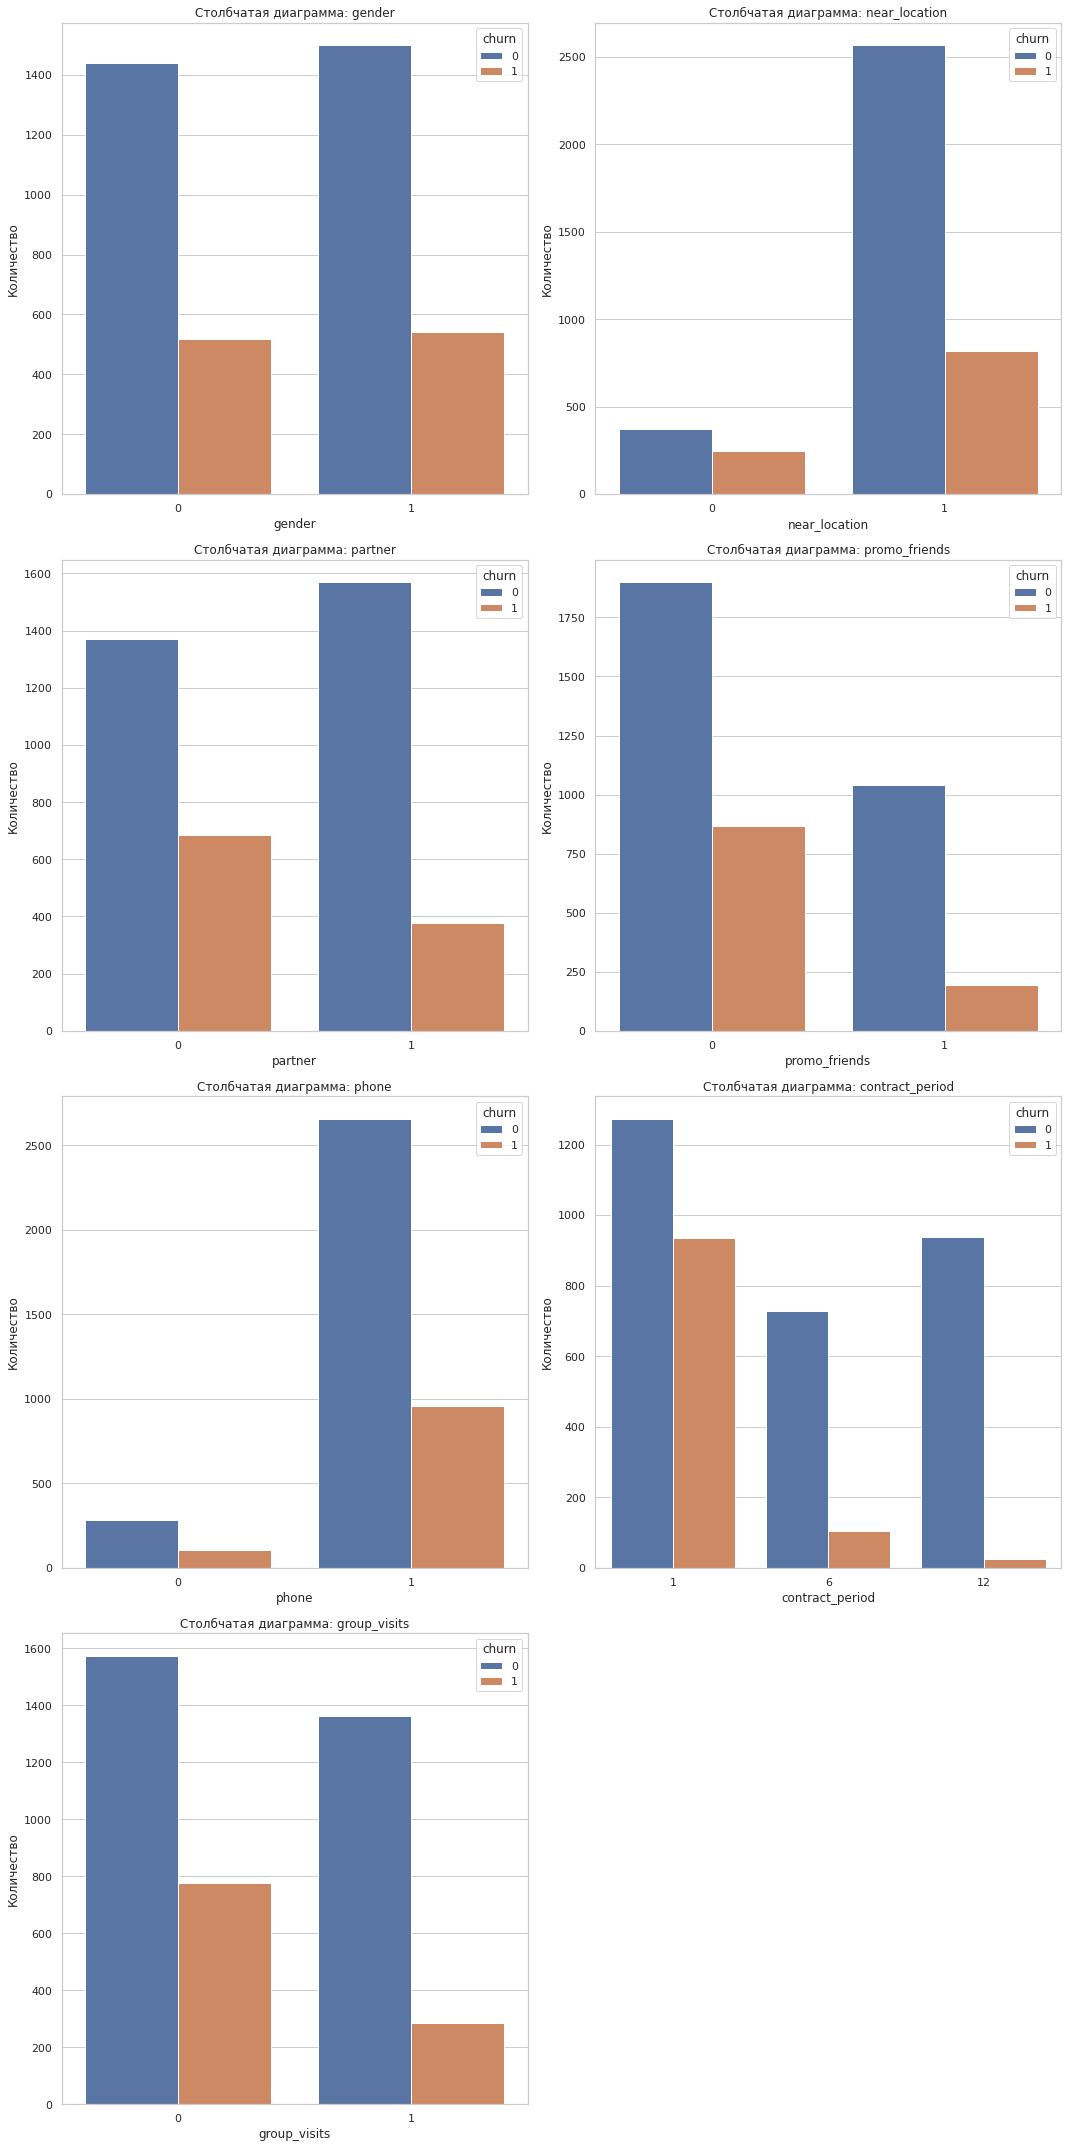

In [13]:
columns_c = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period', 'group_visits']
plot = 'bar'
hue = 'churn'
col_per_row = 2
multiple = 'fill'
kde = False

check_data_g(gym, plot, hue, columns_c, col_per_row, multiple, kde)

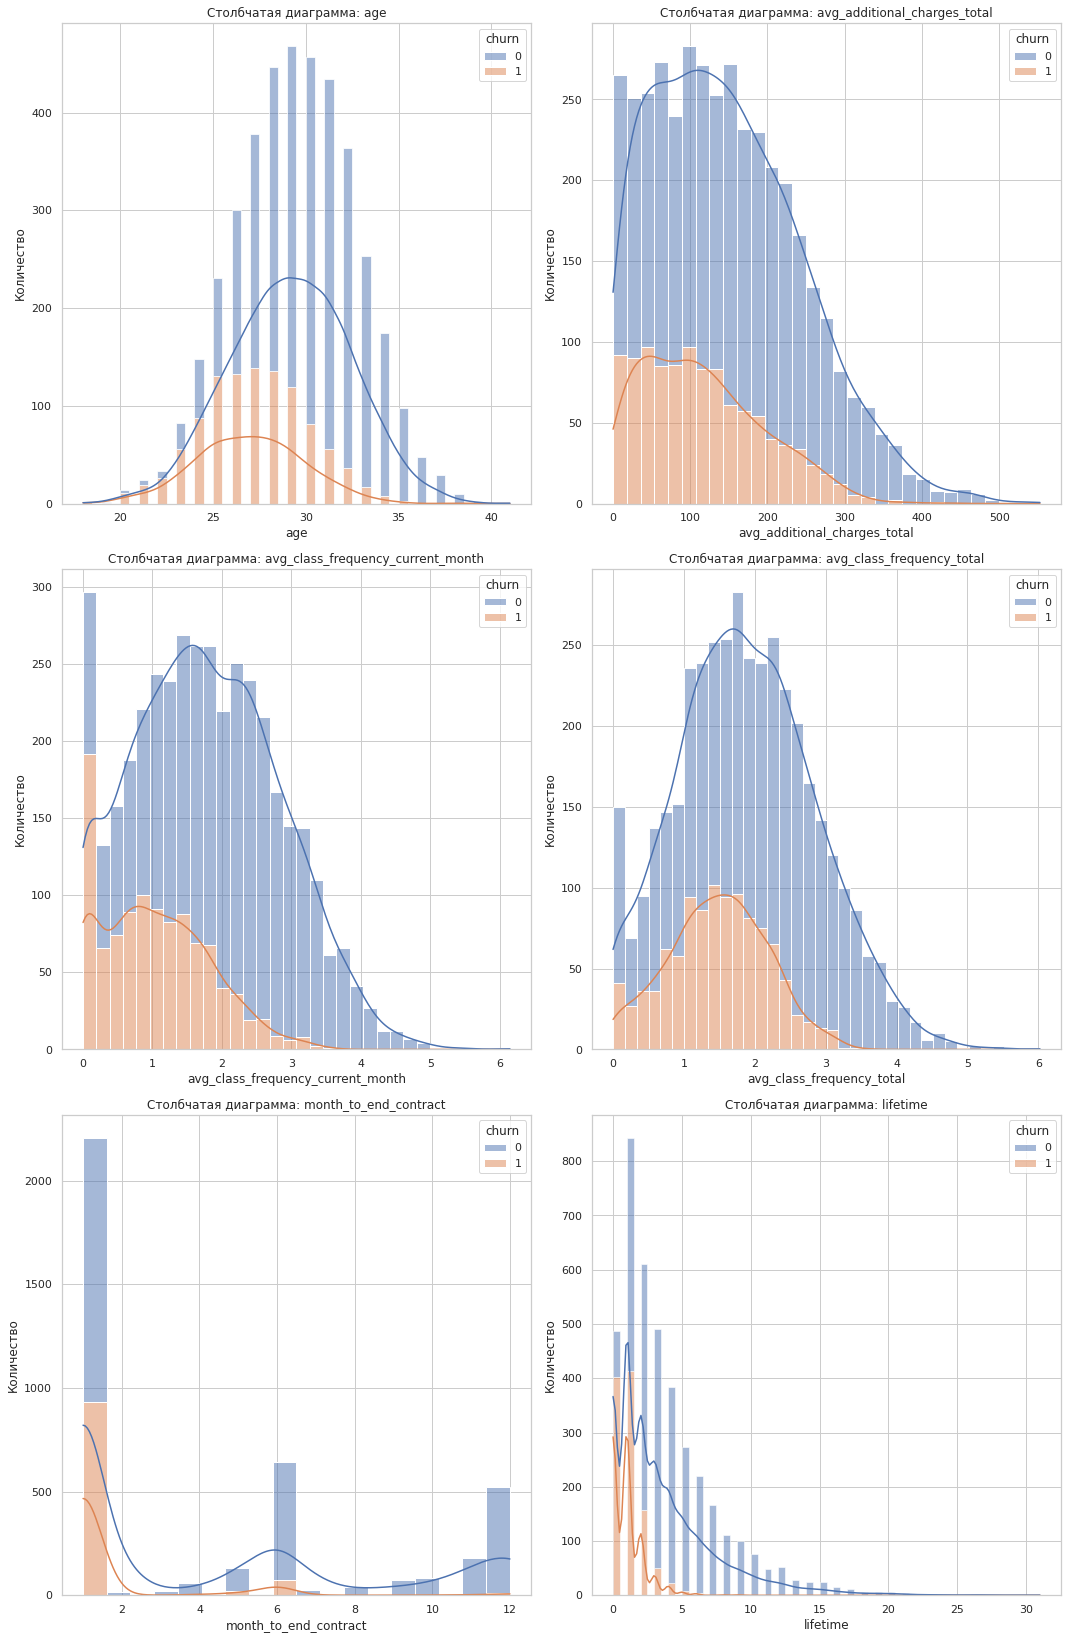

In [14]:
columns_cat = ['age', 'avg_additional_charges_total', 'avg_class_frequency_current_month', 
                   'avg_class_frequency_total', 'month_to_end_contract', 'lifetime']
plot = 'hist'
hue = 'churn'
col_per_row = 2
multiple = 'stack'
kde = True

check_data_g(gym, plot, hue, columns_cat, col_per_row, multiple, kde)

Суммарное предварительное сравнение данных по оттоку пользователей. 

Пользователи по ``gender`` — полу, примерно в одинаково прекращают пользоваться услугами. 

Пользователи по ``near_location`` — по расстоянию до зала, клиенты по этому параметру распределены одинаково для тех, кто не попал в отток по этому месяцу и для тех, кто попал. 

Пользователи по ``partner`` — в отток по большей части попали пользователи, которые пришли не от партнеров зала. Также из тех, кто не попал в отток, клиентов по партнерской программе больше.  

Пользователи по ``promo_friends`` — пользователи, которые пригласили друзей, также как и те, кто не приглашал друзей, отказываются от услуг зала примерно одинаково. 

Пользователи по ``phone`` — которые оставили свой номер телефона и которые нет, примерно одинаково отказываются от услуг зала. 

Пользователи по ``contract_period`` — в отток попадают пользователи, которые оплатили минимальный из тарифов, а в зале остаются пользователи всех тарифов, включая минимальный. 

Пользователи по ``group_visits`` — в отток чаще попадают пользователи, которые не ходят на групповые занятия. 

Пользователи по ``age`` — в отток чаще попадают пользователи до 30 лет, а остаются в зале те пользователи, кому больше 30. 

Пользователи по ``avg_additional_charges_total`` — выручка от пользователей, которые попали в отток и нет примерно схожа, но пользователи, которые не прекратили пользоваться залом тратят примерно на четверть больше пользователей из оттока. 

Пользователи по ``month_to_end_contract`` — чаще всего в отток попадают пользователи, у которых осталось до конца оплаченного периода меньше 2-х месяцев. Пользователей, которые не попали в отток больше всего со сроком до конца периода 1-2 месяца, это в два раза больше пользователей с 6-ю месяцами и 12-ю месяцами. 

Пользователи по ``lifetime`` — пользователи чаще всего попадают в отток после 2-х месяцев пользования залом. В зале же остаются пользователи, которые начали пользоватся услугами зала от 0 месяцев до 6.

Пользователи по ``avg_class_frequency_total`` — в отток попали пользователи, которые ходили в зал не более двух раз в неделю. 
Пользователи, которые не попали в отток ходят в зал от 1 до 3-х раз в месяц. 

Пользователи по ``avg_class_frequency_current_month`` — в отток попали пользователи, которые не ходили в зал, либо ходили один раз. У пользователей, которые не попали в отток значение помесячное такое же, как и общее ``avg_class_frequency_total``. 



<div class="alert alert-warning">
<b>Комментарий 👉</b>

Справочная информация по нашим данным:    
    
1. **gender** - среднее одинаково, следовательно, признак не влияет на отток (с его помощью не удастся "растащить" данные по группам);
    
2. **Near_Location** (проживание или работа в районе, где находится фитнес-центр) - высокий показатель в обоих группах (больше "не оттока" среди тех, кто проживает и работает рядом с фитнесом). Соответственно, отток больше у тех, кто живет дальше. Можно сказать, что бинарный признак "близости к фитнесу" чуть слабее влияет на отток (чуть сильнее на то, чтобы клиент остался с нами);
    
3. **Partner** - это поле демонстрирует положительное влияние на клиентов (среди партнеров оттток меньше);
    
4. **Promo_friends** - это поле демонстрирует положительное влияние на клиентов (среди тех кто воспользовался промо оттток меньше);
    
5. **Phonе** - среднее одинаково, следовательно, признак не влияет на отток (с его помощью не удастся "растащить" данные по группам);
    
6. **Contract_period** (длительность текущего действующего абонемента (в месяцах): 1..6..12) - значительное положительное влияние на клиентов с простым объяснением (купили "длинный" абонемент, деньги терять жалко, будем заниматься);
    
7. **Group_visits** - это поле демонстрирует положительное влияние на клиентов (среди любителей посещать групповые занятия оттток меньше);
    
8. **Age** - среднее практически одинаково, следовательно, признак не влияет на отток (с его помощью не удастся "растащить" данные по группам);
    
9. **Avg_additional_charges_total** (суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон) - небольшое положительное влияние на клиентов (возможно если мы лояльны к фитнесу, то также лояльно относимся и к дополнительным услугам, которые в совокупности образуют экосистему здорового образа жизни);
    
10. **Month_to_end_contract** (срок до окончания текущего действующего абонемента (в месяцах): 1..6..12) - сильное положительное влияние на клиентов (чем больше срок действия моего абонемента - тем вероятнее, что я буду оставаться клиентом центра (возможно жалко "терять" абонемент);
    
11. **Lifetime** (время с момента первого обращения в фитнес-центр (в месяцах): 0..3..31) - очень сильное положительное влияние на клиентов (объяснение: со временем вырабатывается привычка);
    
12. **Avg_class_frequency_total** (средняя частота посещений в неделю за все время с начала действия абонемента) - положительное влияние на клиентов (чем чаще хожу заниматься, тем более мотивирован, очевидно);

13. **Avg_class_frequency_current_month** (средняя частота посещений в неделю за предыдущий месяц) - положительное влияние на клиентов с простым объяснением (чем чаще за неделю клиент ходил в фитнес в ближайщий период, тем привычка сильнее).
</div>


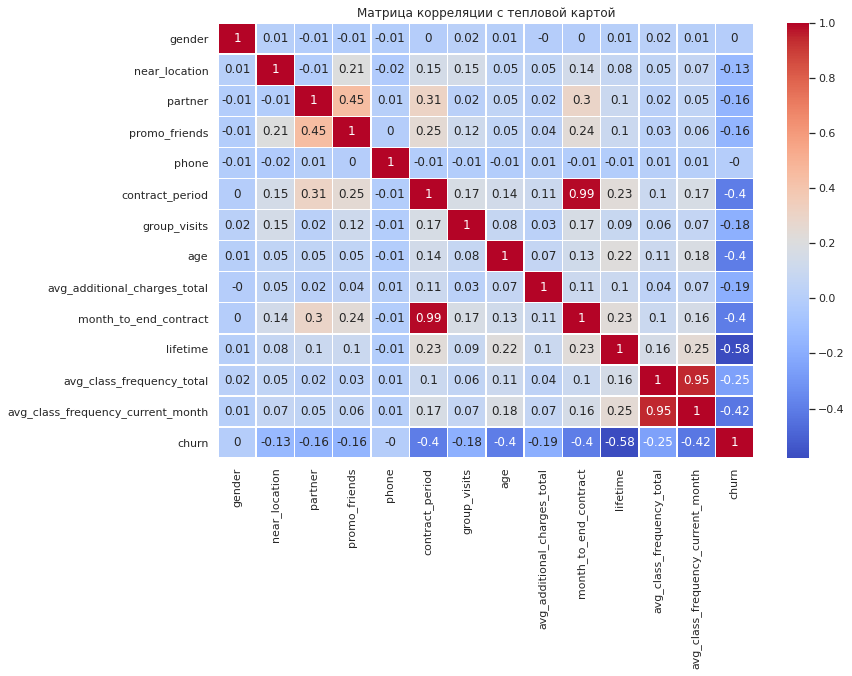

In [15]:
plt.figure(figsize=(12, 8))
sns.heatmap(data=gym.corr(method='spearman').round(2), annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Матрица корреляции с тепловой картой')
plt.show()

Среди данных, помимо очевидной корреляции между сроком до конца оплаченного периода и данными доступных к оплате периодов, а также между частотой посещения зала за все время и за неделю, можно выделить следующие особенности: 
- клиенты с партнерской программой имеют незначительную корреляцию между теми, кто пришел в зал по советам друга, периодом оплаченного периода, а также сроком до конца оплаченного периода;
- нет прямой связи оттока по сроку оплаченного периода, возрасту, продолжительности посещения клуба с его открытия, от дохода продаж дополнительных услуг. 


Данные содержат 14 столбцов с информацией о клиентах фитнес-центра. Проанализированы основные характеристики, такие как пол, удаленность от зала, участие в партнерских программах и акциях, наличие контактного телефона, длительность абонемента, посещение групповых занятий, возраст, выручка от дополнительных услуг. Проведен анализ факторов, влияющих на отток клиентов: пол, удаленность от зала, участие в партнерских программах и акциях, посещение групповых занятий, возраст, выручка от дополнительных услуг, срок до конца абонемента, время с момента первого обращения, частота посещений. 

Предварительно можно отметить, что клиенты, участвующие в партнерских программах и посещающие групповые занятия, менее склонны к оттоку.

<a id="num6"></a>
## Исследование

<a id="num61"></a>
### Логическая регрессия

Построим модель бинарной классификации клиентов с целевым признаком оттока клиентов в следующем месяце. 

In [17]:
X = gym.drop('churn', axis=1) 
y = gym['churn'] 

Проведем анализ на основании обучения выборки с помощью логической регрессии. 

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(X_train_scaled, y_train)

probabilities = model.predict_proba(X_test_scaled)[:, 1]
predictions = model.predict(X_test_scaled)

score(y_test, predictions)

Accuracy: 0.92
Precision: 0.85
Recall: 0.83
F1: 0.84
ROC_AUC: 0.97


По итогам рассчета логичесткой регрессии были получены такие данные: 
- __Accuracy (Доля правильных ответов)__: ``0.92``
Высокая точность указывает на общую эффективность модели в правильном определении классов.
- __Precision (Точность)__: ``0.85``
Эта метрика измеряет, насколько точными являются положительные предсказания модели. Значение 0.86 говорит о том, что 86% клиентов, которых модель отметила как "уходящих", действительно уйдут.
- __Recall (Полнота)__: ``0.83``
Полнота оценивает, как много реальных положительных случаев было обнаружено моделью. Значение 0.83 указывает на то, что модель смогла обнаружить 83% всех действительных случаев оттока.
- __F1-мера__: ``0.84``
F1-мера является средним гармоническим между точностью и полнотой. Значение 0.85 свидетельствует о хорошем балансе между точностью и полнотой.
- __ROC AUC__: ``0.97``
Метрика, используемая для оценки качества бинарной классификации. Значение 0.97 свидетельствует о том, что модель очень хорошо способна предсказывать. 

<a id="num62"></a>
### Случайный лес

Проведем анализ на основании обучения выборки методом случайного леса. 

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = RandomForestClassifier(random_state=0)
model.fit(X_train_scaled, y_train)

probabilities = model.predict_proba(X_test_scaled)[:, 1]
predictions = model.predict(X_test_scaled)

score(y_test, predictions)

Accuracy: 0.92
Precision: 0.84
Recall: 0.81
F1: 0.83
ROC_AUC: 0.97


По итогам обучения выборки с помощью случайного леса были получены следующие результаты: 
- __Accuracy (Доля правильных ответов)__: ``0.91``
Точность 0.91 указывает на общую эффективность модели в правильном определении классов. 
- __Precision (Точность)__: ``0.83``
Precision на уровне 0.83 говорит о том, что 83% клиентов, которых модель отметила как "уходящих", действительно уйдут.
- __Recall (Полнота)__: ``0.81``
Полнота в 0.81 означает, что модель обнаруживает 81% всех действительных случаев оттока. Это может быть интерпретировано как то, что модель пропускает 19% реальных случаев оттока.
- __F1-мера__: ``0.82``
Значение F1-меры равное 0.82 свидетельствует о сбалансированности между точностью и полнотой для данной модели случайного леса.
- __ROC AUC__: ``0.97``
Метрика, используемая для оценки качества бинарной классификации. Значение 0.97 свидетельствует о том, что модель очень хорошо способна предсказывать. 

<a id="num63"></a>
### Сравнение метрик

В случае этой задачи на отток клиентов, важным критерием будет полнота __Recall__. Полнота измеряет, как много реальных положительных случаев было обнаружено моделью. Высокий Recall означает, что модель хорошо способна выявлять клиентов, которые фактически уйдут.

С учетом этой задачи, логистическая регрессия показала немного лучший __Recall__ полноту по сравнению со случайным лесом ``0.83`` против ``0.81``. Таким образом, в данном контексте, логистическая регрессия, с учетом предоставленных метрик, может быть более предпочтительной моделью для задачи с оттоком. 

<a id="num64"></a>
### Дендрограмма

Построим дендрограмму для этих данных. 

In [20]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)
linked = linkage(X_sc, method = 'ward') 

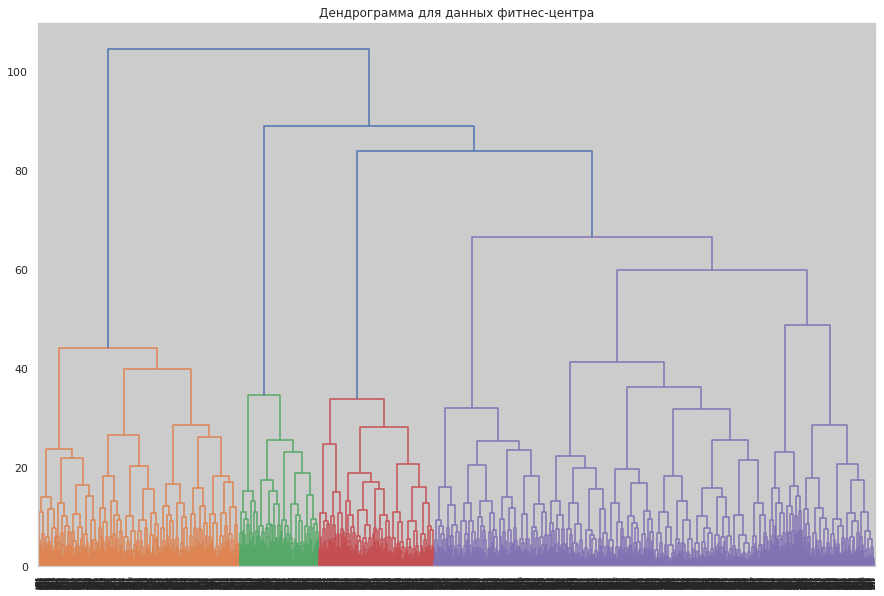

In [21]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендрограмма для данных фитнес-центра')
plt.show() 

Можно выделить две основные группы: 

- __Три малых кластера__:
Три части дендрограммы, занимающие примерно половину пространства, представляют собой три малых кластера. Каждый из этих кластеров содержит набор данных, который довольно сильно отличается от данных в других кластерах, но каждый из них представлен как относительно небольшой, в сравнении с четвертым и самым большим кластером.  

- __Одиночный большой кластер__:
Четвертая часть, занимающая оставшиеся 50% пространства, представляет собой отдельный, наибольший кластер.

Разделение данных на несколько кластеров с разным размером указывает на разнообразие внутри набора данных. Три малых кластера могут представлять различные группы или паттерны, в то время как одиночный большой кластер может быть некоторым образом уникальным.

Важно обратить внимание на крупный кластер, поскольку он, вероятно, содержит определенные схожие группы объектов. 

<a id="num65"></a>
### Алгоритм K-Means

Обучим модель кластеризации на основании алгоритма K-Means и оценим результаты.

In [22]:
km = KMeans(n_clusters=5, random_state=0, n_init=10)

labels = km.fit_predict(X_sc)

gym['cluster'] = labels

cluster_means = gym.groupby('cluster').mean()
display(cluster_means)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster,,,,,,,,,,,,,,
0,0.502970,0.959406,0.783168,0.574257,1.000000,10.889109,0.542574,29.982178,160.761016,9.954455,4.736634,1.982055,1.974789,0.027723
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,0.559666,0.976134,0.356802,0.230310,0.998807,2.669451,0.473747,30.125298,161.657905,2.459427,4.898568,2.852002,2.850161,0.068019


In [23]:
cluster_features = gym.groupby('cluster').mean().reset_index()
numeric_columns = cluster_features.drop(columns=['cluster']).columns
cluster_features.style.format({i: '{:.2f}' for i in numeric_columns}) \
        .highlight_max(color='yellowgreen', subset=numeric_columns) \
        .highlight_min(color='coral', subset=numeric_columns)
cluster_features.T.style.background_gradient(cmap='coolwarm', axis=1)

,0,1,2,3,4
cluster,0.000000,1.000000,2.000000,3.000000,4.000000
gender,0.502970,0.522078,0.495050,0.485737,0.559666
near_location,0.959406,0.862338,0.000000,1.000000,0.976134
partner,0.783168,0.470130,0.463366,0.350238,0.356802
promo_friends,0.574257,0.306494,0.079208,0.240095,0.230310
phone,1.000000,0.000000,1.000000,1.000000,0.998807
contract_period,10.889109,4.787013,2.352475,1.948494,2.669451
group_visits,0.542574,0.425974,0.215842,0.341521,0.473747
age,29.982178,29.301299,28.477228,28.167987,30.125298
avg_additional_charges_total,160.761016,143.957664,135.457501,131.622204,161.657905


In [24]:
columns_per_row = 2 
columns_c = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period', 'group_visits']
columns_cat = ['age', 'avg_additional_charges_total', 'avg_class_frequency_current_month', 
               'avg_class_frequency_total', 'month_to_end_contract', 'lifetime']

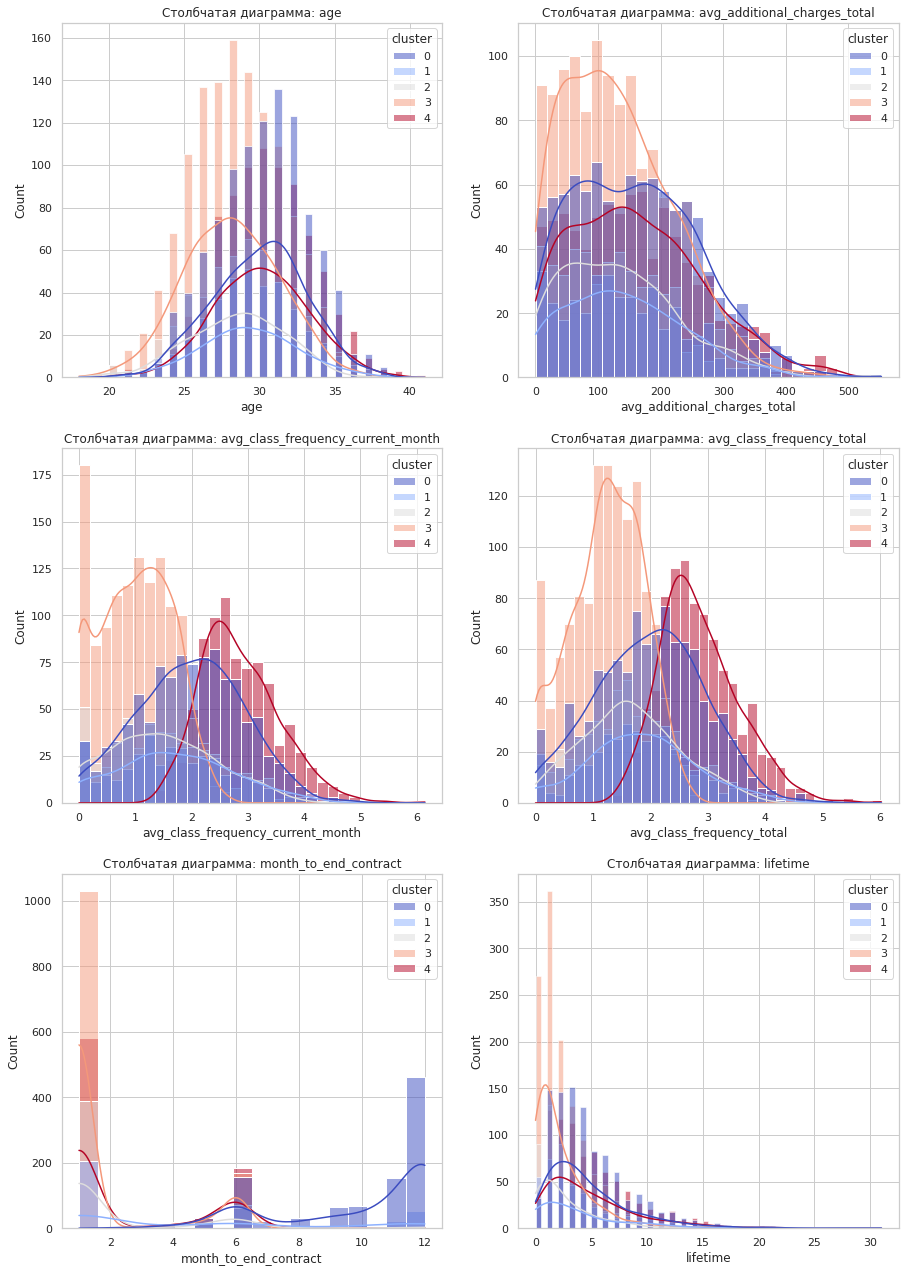

In [25]:
sns.set(style="whitegrid")
plt.figure(figsize=(15, 30))

for i, column in enumerate(columns_cat, 1):
    plt.subplot(len(columns_cat) // columns_per_row + 1, columns_per_row, i)
    sns.histplot(x=column, hue='cluster', palette='coolwarm', data=gym, kde=True)
    plt.title(f'Столбчатая диаграмма: {column}')  # Добавление заголовка
plt.show()

Можно выделить следующие особенности каждого из кластеров: 

1. **Возраст:**
   - Кластер 3: Один из самых "молодых", наиболее представленных в данных.
   - Кластеры 1 и 2: Преимущественно до 30 лет, наименее представлены в данных.
   - Кластер 4: В возрасте преимущественно 30 лет.
   - Кластер 0: Пользователи за 30 лет, хорошо представлены в данных.

2. **Средние дополнительные расходы (avg_additional_charges_total):**
   - Кластер 3: Больше всего совершает покупок, преобладают суммы до 200.
   - Кластеры 0 и 4: Меньше совершают покупки, но суммы преимущественно до 300.
   - Кластеры 1 и 2: Совершают меньше остальных покупок, преобладают суммы до 200.

3. **Средняя частота посещений в текущем месяце (avg_class_frequency_current_month):**
   - Кластер 3: Не посещает зал или ходит 1-2 раза в неделю.
   - Кластер 4: Ходит 3-4 раза в неделю в зал, но посещений практически нет.
   - Кластер 0: Стабильно ходит в зал 1-3 раза в неделю, не очень часто пропускает.
   - Кластеры 1 и 2: Ходят в зал меньше остальных, преимущественно 0-2 раз в неделю.

4. **Средняя частота посещений за всё время (avg_class_frequency_total):**
   - Значения крайне похожи на данные за месяц.

5. **Месяцев до окончания контракта (month_to_end_contract):**
   - Кластеры 3, 2, 4: В основном 0-1 месяцев до конца оплаченного пакета услуг.
   - Кластер 0: В основном 12 месяцев до конца оплаченного пакета услуг.
   - Кластер 1: Количество месяцев до конца контракта в каждом промежутке без аномалий.

6. **Время существования аккаунта (lifetime):**
   - Кластер 3: Недавно пользуется услугами, от 0 до 2 месяцев, но наиболее многочисленен.
   - Кластер 2: Не многочислен, но клиенты обратились в зал первый раз не сильно более 1 месяца назад.
   - Кластеры 0 и 4: Менее малочислены, но клиенты обратились в зал 3 и более месяцев назад.
   - Кластер 1: Малочислен и посетил зал примерно 2 месяца назад.

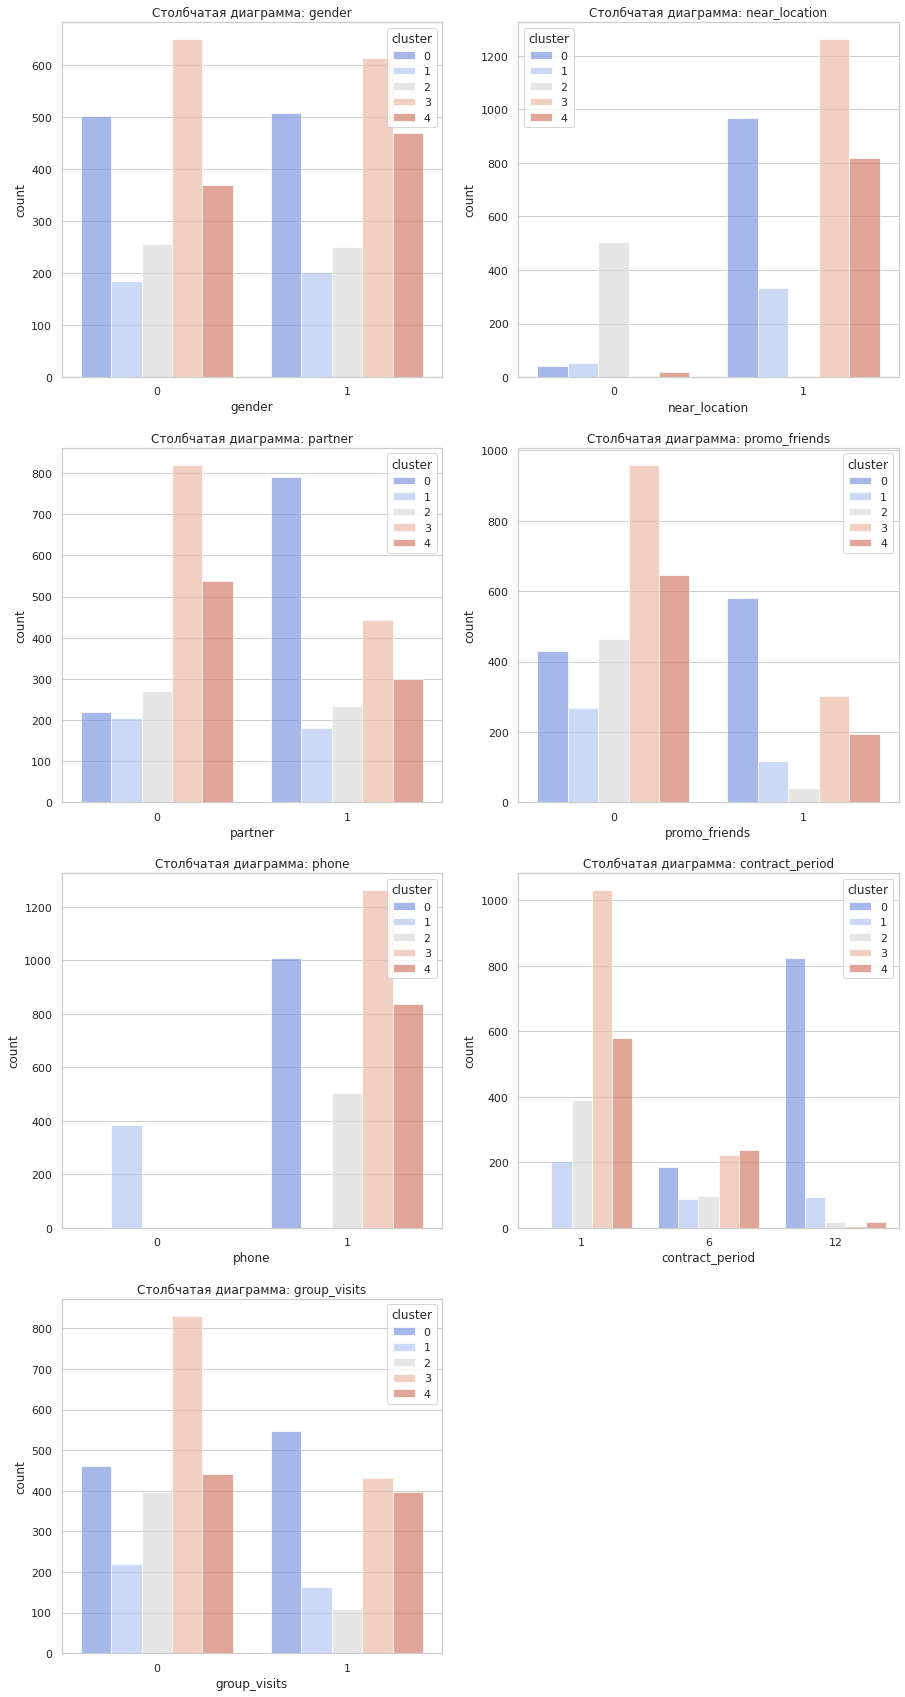

In [26]:
plt.figure(figsize=(15, 30))

for i, column in enumerate(columns_c, 1):
    plt.subplot(len(columns_cat) // columns_per_row + 1, columns_per_row, i)
    sns.countplot(x=column, hue='cluster', data=gym, palette='coolwarm', alpha=0.7)
    plt.title(f'Столбчатая диаграмма: {column}')  # Добавление заголовка
plt.show()

Можно выделить следующие особенности каждого из кластеров: 

1. **Пол:**
   - Кластер 3 и 0: преодставлен наибольшим количеством для обоих полов. 
   - Кластер 1: представлен наименьшим количеством для обоих полов. 

2. **Местоположение клиента относительно расположения зала:**
   - Кластер 3: пользователи этого кластера всегда находятся в одном районе с залом. 
   - Кластер 1: малое количество клиентов из этого кластера находятся в одном районе с залом. 
   - Кластер 2: клиенты из этого кластера не находятся в одном районе с залом. 
   - Кластер 0: преимущественно находятся в одном районе с залом. 
   - Кластер 4: пользователи преимущественно находятся в одном районе с залом, крайне малая часть клиентов находится от зала далеко. 
   
3. **Партнерская программа:**
   - Кластер 0: большая часть клиентов пришла по партнерской программе. 
   - Кластер 1: меньше всего клиентов из этого кластера были приведены от партнеров зала.
   - Кластер 3 и 4: больше всего пользователей из этих кластеров пришли в зал сами, а не по партнерской программе. 
   - Кластер 2: клиенты, которые пришли по партнерской программе и те, которые пришли сами представлены примерно в одинаковом количестве. 
   
4. **Программа «Приведи друга»:**
    - Кластер 0: больше остальных были приглашены друзьями. 
    - Кластеры 1, 2, 3 и 4: в основном пришли в зал сами, но есть случаи, когда пользователи из этих кластеров были приглашены друзьями.
    
5. **Телефон:**
    - Кластер 1: пользователи у которых не указан телефон.
    - Кластеры 2, 3, 4 и 0: пользователи у которых телефон указан. 

6. **Пакеты тарифов:**
    - Кластеры 3, 4 и 2: чаще всего покупают пакеты на 1 месяц. 
    - Кластер 0: не покупает пакеты на 1 месяц, а только на 12 и изредка на 6. 
    - Кластер 1: покупает все тарифы почти одинаково, но тариф на 1 месяц все же несколько чаще. 
    
7. **Групповые занятия:**
    - Кластер 3 и 0: чаще ходят на групповые занятия, чем не ходят. 
    - Кластеры 1, 4 и 2: чаще всего не ходят на групповые занятия. 

<a id="num66"></a>
### Сводка

На основании выведенной информации можно составить представления о кластерах и поделить их на условные группы. 

**Кластер 0 (Предоплаченные пакеты):**
   - **Характеристики:**
     - Преимущественно выбирают предоплаченные пакеты на 12 месяцев.
     - Равномерно распределены по возрасту в диапазоне от 23 до 37 лет.
     - Траты активны, но не такие высокие, как у других кластеров.
     - Равномерно ходят в зал по количеству дней в неделю.
     - Чаще других представлены в программе от компаний-партнеров.
     - Преобладают пользователи, которые приглашают друзей и активно посещают зал от 0 до 5 дней в неделю.
   - **Отток:** В редких случаях попадают в отток.

**Кластер 1 (Пользователи без телефона):**
   - **Характеристики:**
     - Пользователи, не оставившие телефон, попадают в этот кластер.
     - Преобладают в общем числе пользователей.
     - Ходят в зал от 0 до 4 раз в неделю.
     - Траты активны, но не наивысшие.
   - **Отток:** В некоторых случаях попадают в отток, но конкретной тенденции не получится выделить.

**Кластер 2 (Менее активные):**
   - **Характеристики:**
     - Основные траты в промежутке от 0 до 300 единиц.
     - Ходят в зал от 0 до 3 раз в неделю.
     - Пользователи в основном молодые, равномерно распределены по возрасту.
   - **Отток:** Попадают в отток, но не по всем параметрам, конкретной тенденции нет.

**Кластер 3 (Менее активные, частично не ходят в зал):**
   - **Характеристики:**
     - Основные траты в промежутке от 0 до 300 единиц.
     - Ходят в зал от 0 до 3 раз в неделю, кластер 3 не ходит в зал больше 3 раз в неделю.
     - Пользователи в возрасте от 19 до 34 лет чаще попадают в отток.
   - **Отток:** Большая часть пользователей из этого кластера попадает в отток.

**Кластер 4 (Активные занимающиеся):**
   - **Характеристики:**
     - Чаще всего ходят в зал от 2 до 6 раз в неделю.
     - Траты активны, часто пользуются дополнительными услугами.
     - Меньше попадают в отток по сравнению с другими кластерами.
     - Чаще всего представлены полом 0. 
   - **Отток:** Пользователи из этого кластера меньше попадают в отток.

**Общие тенденции:**
   - Активный приток клиентов был не ранее 15 месяцев назад.
   - Пользователи из кластеров 1-4 имеют от 0 до 6 месяцев до конца периода.
   - Кластер 0 имеет самый большой срок до конца периода.
   - Пользователи, не попавшие в отток, больше всего тратят на дополнительные услуги (до 500 единиц).
   - Пользователи пришедшие по партнерской программе приглашались в прошлом году очень активно. Можно предположить, что были запущены выгодные предложения для партнеров. 

<a id="num67"></a>
### Отток по кластерам

Посмотрим по кластерам отток пользователей. 

In [27]:
churn_by_cluster = gym.groupby('cluster')['churn'].mean()
display(churn_by_cluster)

cluster
0    0.027723
1    0.267532
2    0.443564
3    0.514263
4    0.068019
Name: churn, dtype: float64

In [28]:
display(f'Кластер 0 (Предоплаченные пакеты): {churn_by_cluster.index[0]}:                   Доля оттока - {churn_by_cluster.iloc[0]:.2%}')
display(f'Кластер 1 (Пользователи без телефона): {churn_by_cluster.index[1]}:               Доля оттока - {churn_by_cluster.iloc[1]:.2%}')
display(f'Кластер 2 (Менее активные): {churn_by_cluster.index[2]}:                          Доля оттока - {churn_by_cluster.iloc[2]:.2%}')
display(f'Кластер 3 (Менее активные, частично не ходят в зал): {churn_by_cluster.index[3]}: Доля оттока - {churn_by_cluster.iloc[3]:.2%}')
display(f'Кластер 4 (Активные занимающиеся): {churn_by_cluster.index[4]}:                   Доля оттока - {churn_by_cluster.iloc[4]:.2%}')

'Кластер 0 (Предоплаченные пакеты): 0:                   Доля оттока - 2.77%'

'Кластер 1 (Пользователи без телефона): 1:               Доля оттока - 26.75%'

'Кластер 2 (Менее активные): 2:                          Доля оттока - 44.36%'

'Кластер 3 (Менее активные, частично не ходят в зал): 3: Доля оттока - 51.43%'

'Кластер 4 (Активные занимающиеся): 4:                   Доля оттока - 6.80%'

<a id="num7"></a>
## Выводы

По итогам проекта можно выделить следующие моменты о клиентах и метриках. 

**Кластеризация клиентов:**
   - **Кластер 0 (Предоплаченные пакеты):**
      - Преимущественно выбирают предоплаченные пакеты на 12 месяцев.
      - Траты активны, равномерно ходят в зал, редко попадают в отток.
   - **Кластер 1 (Пользователи без телефона):**
      - Преобладают в общем числе, активные траты, ходят в зал от 0 до 4 раз в неделю.
      - В некоторых случаях попадают в отток, требуется анализ.
   - **Кластер 2 (Менее активные):**
      - Основные траты в промежутке от 0 до 300 единиц, ходят в зал от 0 до 3 раз в неделю.
      - Попадают в отток, но без четкой тенденции.
   - **Кластер 3 (Менее активные, частично не ходят в зал):**
      - Основные траты в промежутке от 0 до 300 единиц, ходят в зал не более 3 раз в неделю.
      - Большая часть попадает в отток, особенно пользователи 19-34 лет.
   - **Кластер 4 (Активные занимающиеся):**
      - Частые посещения зала (2-6 раз в неделю), активные траты.
      - Меньше попадают в отток по сравнению с другими кластерами.

**Общие тенденции:**
   - **Активный приток клиентов:** Был не ранее 15 месяцев назад, стоит продолжать улучшение стратегий удержания.
   - **Срок до конца периода:** Кластер 0 имеет самый большой срок, остальные имеют от 0 до 6 месяцев.
   - **Траты на дополнительные услуги:** Пользователи, не попавшие в отток, больше всего тратят (до 500 единиц).

**Метрики моделей:**
   - Обе модели (логистическая регрессия и случайный лес) эффективны с высокой точностью и способностью предсказывать отток.
   - Логистическая регрессия имеет небольшое преимущество по Recall.

<a id="num8"></a>
## Рекомендации

**Логистическая регрессия для выявления оттока:**
   - С учетом более высокого Recall, рекомендуется использовать логистическую регрессию для выявления клиентов, склонных к оттоку.

**Кластеризация клиентов:**
   - Используя данные о кластерах, можно принять следующие меры:
      - **Кластер 0 (Предоплаченные пакеты):** Поддерживать высокий уровень обслуживания и предлагать дополнительные услуги для удержания. Продолжать предлагать удобные условия для компаний-партнеров. 
      - **Кластер 1 (Пользователи без телефона):** Провести анализ, почему они не оставляют телефоны. Возможно, предложить какие-то бонусы за предоставление контактной информации, либо исправить внутренние моменты, если это ошибка. 
      - **Кластер 2 и 3 (Менее активные):** Разработать программы мотивации для увеличения активности, возможно, предложить скидки на следующий абонемент.
      - **Кластер 4 (Активные занимающиеся):** Уделять внимание улучшению дополнительных услуг, так как это может стать ключевым моментом для удержания.

**Общие тенденции:**
   - **Активный приток клиентов:** Уделять внимание улучшению стратегий удержания через бонусные программы и предложения. Активный приток клиентов был примерно 15 месяцев назада, стоит изучить предыдущий опыт и, возможно, адаптировать его под текущие условия.
   - **Траты на дополнительные услуги:** Клиенты, не попавшие в отток, больше всего тратят на дополнительные услуги. Развивать и расширять этот аспект бизнеса.

**Срок до конца периода:**
   - **Кластер 0 (Предоплаченные пакеты):** Сосредоточить маркетинговые усилия на продлении абонементов.
   - **Кластеры 1-4:** Проактивно предлагать продление абонементов, предлагая специальные предложения и скидки.

**Отток по кластерам:**
   - **Фокус на кластерах с высоким оттоком (кластеры 1, 2, 3):** Разработать персонализированные программы удержания для снижения оттока.
   - **Мониторинг кластера 4:** Следить за изменениями в активности клиентов из кластера 4 и поддерживать их уровень удовлетворенности.

**Обратная связь и анализ причин оттока:**
   - Собирать обратную связь от клиентов, покидающих фитнес-центр, для анализа причин и внесения улучшений.

**Мониторинг и адаптация:**
   - Регулярно мониторить эффективность предпринятых мер и адаптировать стратегии удержания в соответствии с изменениями в поведении клиентов.


<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>Спасибо за ревью. Критические замечания исправил. Отдельно благодарю за предоставленный факультативный материал, ценю накопленный опыт от наставников передаваемый поколениям!</font>
</div>

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b>

Сергей, был рад помочь! Был рад работать с тобой совместно над проектом! ПРОЕКТ ПРИНЯТ!
    
p.s. загляни сейчас в эл/почтовый ящик ...    
</div>